# Data Science Portfolio: Emergency Department Admission Classification #

This is a data science portfolio for upcoming DSDA conference in May 25, 2018. The dataset used in this project is a proprietary dataset which was simulated by University of Toronto IHPME "Big Data Analytics for Healthcare" course offered in 2015.

** Problem Statement: ** emergency department (ED) visit is a fast wast of getting a hospital admission especially during weekends and holidays. However, not every patient requires and immediate ED admission and prioritizing the cases by risk severity within ED units has been a real challenge for Canadian health care system. In this simulation study, a random set of patients attended ED visits were followed and the cases admitted to hospital were recorded. 

The ED admission dataset contains various kind of features which helps to indicate the ED admitted cases for each patient. These include demographic factors (i.e., distance, avg. income, gender, ethnicity), diagnostic factors (i.e., referral diagnosis code, tests, pain score, nausia score) and patient medical history (i.e., medications taken and family history).

** Goal: ** to develop a supervised learning based classification model which can predict the probability of patients who require an immediate ED admission among the sample. This will help ED unit managers and a group of clinicians to identify urgent cases for providing improved quality of care (i.e., reduced ED wait time, reduced ED volume of visits etc.).

## Data Wrangling ##
This phase is concerend with data cleaning like missing value replacement by feature impuation, handling outliers, format data type and feature transformation (i.e., feature encoding) on training dataset. Thus, final transformed dataset will be ready to get feed into different types of classification models.

In [1]:
###############################################################################
# Data Science Portfolio: ED Admission Data Wrangling
###############################################################################
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from pandas_ml import ConfusionMatrix
from sklearn.metrics import roc_curve, auc
from scipy import interp

df = pd.read_csv('ED_train.csv')
print(df.head())

# Drop unnecessary column: 'key'
df = df.drop(['Key'], axis=1)

# Check drop duplicates: drop 923 rows
df = df.drop_duplicates()

    Key  Gender Ethnicity LIHN  Avg_Income  Distance Admission_Date  \
0  1821     1.0         C    8         NaN       NaN     11/17/2013   
1  2018     0.0         C    N         NaN       NaN       5/6/2012   
2  2176     1.0         A    8         NaN       NaN     12/15/2013   
3  2719     1.0         C    N         NaN       NaN      4/25/2013   
4  2734     1.0         O    N         NaN       NaN       1/8/2014   

   GP_Visits  ED_Visits  Specialist_Visits  ...    Symptom2Visit_Days  Test_A  \
0          1          0                  0  ...                    10       N   
1          7          1                  0  ...                    28       N   
2          1          0                  0  ...                     9       N   
3          6          0                  0  ...                    17       N   
4          1          0                  0  ...                     8       N   

     Test_B   Test_C    Test_D Test_E  Test_F  Test_G  Test_H  Admit  
0  0.157895  0.

### Check # of missing value counts and percentage ###

In [2]:
# Check number of missing values and datatypes in dataframe:
df.info()

# Compute missing value stat.: pre-data cleansing
ED_missing = df.isnull().sum()
ED_missing = pd.DataFrame(ED_missing)
ED_missing.columns = ['missing_value_counts']
ED_missing['missing_PCT'] = (ED_missing['missing_value_counts']/df['GP_Visits'].count())*100

# sort values by missing percent(%):
ED_missing = ED_missing.sort_values(by='missing_PCT',ascending=False)
ED_missing

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64612 entries, 0 to 65534
Data columns (total 30 columns):
Gender                  61869 non-null float64
Ethnicity               51100 non-null object
LIHN                    64612 non-null object
Avg_Income              50062 non-null float64
Distance                51127 non-null float64
Admission_Date          64612 non-null object
GP_Visits               64612 non-null int64
ED_Visits               64612 non-null int64
Specialist_Visits       64612 non-null int64
Hospital_Admissions     64612 non-null int64
Total_Visits            64612 non-null int64
MRI_Count               64612 non-null int64
Referral_Diagnosis_1    31559 non-null object
Referral_Diagnosis_2    17725 non-null object
GP_Code                 53532 non-null object
Pain_Score              64612 non-null int64
Nausia_Score            14595 non-null float64
Allergy                 64612 non-null int64
Previous_Medication     64612 non-null int64
Family_History        

,missing_value_counts,missing_PCT
Nausia_Score,50017,77.411317
Referral_Diagnosis_2,46887,72.567015
Test_H,45358,70.200582
Referral_Diagnosis_1,33053,51.156132
Avg_Income,14550,22.519037
Ethnicity,13512,20.912524
Distance,13485,20.870736
GP_Code,11080,17.148517
Gender,2743,4.245341
Test_G,107,0.165604


### Compute Summary Statistics: pre-data cleansing ###
Computer summary statistics and report on numerical features only!

In [3]:
# Compute summary stat.: pre-data cleansing #
###############################################################################
# Note: NO stats computed for categorical variables (nominal & ordinal features)
ED_Summary = df.describe().T
ED_Summary = ED_Summary[['count','min','max','mean','25%','50%','75%','std']]
ED_Summary = ED_Summary.drop(['Gender','Allergy','Family_History',
                              'Test_B','Test_C','Test_D','Admit'])
ED_Summary

,count,min,max,mean,25%,50%,75%,std
Avg_Income,50062.0,7117.000000,200001.000000,48016.687168,32474.000000,43125.000000,58257.000000,20693.475138
Distance,51127.0,0.417124,4798.898626,385.668065,112.879164,176.245146,529.964132,413.693007
GP_Visits,64612.0,0.000000,56.000000,1.233734,0.000000,1.000000,1.000000,1.699228
ED_Visits,64612.0,0.000000,8.000000,0.350771,0.000000,0.000000,1.000000,0.550946
Specialist_Visits,64612.0,0.000000,9.000000,0.556878,0.000000,0.000000,1.000000,0.652588
Hospital_Admissions,64612.0,0.000000,5.000000,0.041509,0.000000,0.000000,0.000000,0.228201
Total_Visits,64612.0,1.000000,58.000000,2.182938,1.000000,2.000000,2.000000,1.888086
MRI_Count,64612.0,0.000000,2.000000,0.036510,0.000000,0.000000,0.000000,0.192927
Pain_Score,64612.0,1.000000,5.000000,4.105460,3.000000,5.000000,5.000000,1.433807
Nausia_Score,14595.0,1.000000,4.000000,2.773621,2.000000,2.000000,4.000000,0.953347


### Handling outliers with inter-quartile range (IQR) method ###
Outliers are the values that might potentialy skew the results on our modeling. In order to optmize the performance of ML models, it is required to handle outliers properly. In this train set, there are 3 numerical features and a outlier detection dataframe was created. 

Easily, it was easy to identify there are outlier(s) in "body mass index" and "avg_glucose_level". The max. value on each of feature is greater than the upper bound value computed IQR method. Therefore, conclusion can be made here that outliers are detected on bmi and avg_glucose_level!

In [4]:
# Handling outliers #
# Compute IQR, LowerBound and UpperBound
ED_Summary['IQR'] = ED_Summary['75%'] - ED_Summary['25%'] 
ED_Summary['LB'] =  ED_Summary['25%'] - 1.5*ED_Summary['IQR']   
ED_Summary['UB'] =  ED_Summary['75%'] + 1.5*ED_Summary['IQR']

# Extract dataframe:
ED_outliers = ED_Summary[['LB','min','UB','max']]
print(ED_outliers)

# Test how many features have outliers: 10 features
ED_outliers['UB'] < ED_outliers['max']

                              LB          min            UB            max
Avg_Income          -6200.500000  7117.000000  96931.500000  200001.000000
Distance             -512.748287     0.417124   1155.591583    4798.898626
GP_Visits              -1.500000     0.000000      2.500000      56.000000
ED_Visits              -1.500000     0.000000      2.500000       8.000000
Specialist_Visits      -1.500000     0.000000      2.500000       9.000000
Hospital_Admissions     0.000000     0.000000      0.000000       5.000000
Total_Visits           -0.500000     1.000000      3.500000      58.000000
MRI_Count               0.000000     0.000000      0.000000       2.000000
Pain_Score              0.000000     1.000000      8.000000       5.000000
Nausia_Score           -1.000000     1.000000      7.000000       4.000000
Previous_Medication     0.000000     0.000000      0.000000       3.000000
Symptom2Visit_Days     -8.000000     3.000000     48.000000     228.000000
Test_E                 -4

Avg_Income              True
Distance                True
GP_Visits               True
ED_Visits               True
Specialist_Visits       True
Hospital_Admissions     True
Total_Visits            True
MRI_Count               True
Pain_Score             False
Nausia_Score           False
Previous_Medication     True
Symptom2Visit_Days      True
Test_E                 False
Test_H                 False
dtype: bool

### Removal of outliers and drop useless feature ###
Before remove outliers on these two features, test how many observations are affected.
This is critical because while removing outliers we want to preserve positive "stroke cases" as much as possible.

In [5]:
# Test removing outliers: 
# Avg_Income: drop = 1541 rows
df.drop(df[df['Avg_Income'] > ED_outliers.loc['Avg_Income']['UB']].index)
# GP_Visits: drop = 8804 rows 
df.drop(df[df['GP_Visits'] > ED_outliers.loc['GP_Visits']['UB']].index)

# Distance: drop = 3940 rows
df = df.drop(df[df['Distance'] > ED_outliers.loc['Distance']['UB']].index)

### Feature Encoding ###
Feature encoding is a process where feature are encoded into right format. There are two types of feature encoding: ordinal and nominal feature encoding. Ordinal feature encoding is a type of encoding where feature actually contains information about "order" like increase or decrease in value (i.e., score level, date, etc). Whereas nominal feature encoding is a type of encoding where feature contains a class of label like gender (i.e., male or female). 

** Nominal feature encoding: ** allergy and previous_medication.
These two feature(s) have meaning of different class labels being "Yes" or "No" but already pre-encoded as numerical value(s) being "1" or "0". The main reason why these feature getting re-encoded back into word string is for exploratory data analysis phase. It is best practice to keep data format consistent and convert for easier interpretation when perfoming data exploration like a string value of "Yes" or "No".

In [6]:
###########################
# Nominal feature encoding:
###########################
# Define manual map: Gender_map
Gender_map = {0:'Female', 1:'Male'}
# Define manual map: Yes_No_map
Yes_No_map = {0:'No', 1:'Yes'}

# Inverse transform back to original value map:
inv_Gender_map = {v: k for k, v in Gender_map.items()}
inv_Yes_No_map = {v: k for k, v in Yes_No_map.items()}

** Ordinal feature encoding: ** admission_date. 
Admission date is a feature where it has a order of date from year 2009 to 2014.

Thus, Admission date gets mapped into numerical values then gets printed after ordinal feature encoding for checking data consistency.

In [7]:
###########################
# Ordinal feature encoding:
###########################
# Admission_Date #
###############################################################################
df['Admission_Date'] = pd.to_datetime(df['Admission_Date'], format='%m/%d/%Y')
df['Admission_Date'].sort_values(ascending=True)

adm_date_mapping = {label:idx for idx, label in
                 enumerate (np.unique(df['Admission_Date']))}

# Use adm_date_mapping to transform the Admission_Date into integers:
df['Admission_Date'] = df['Admission_Date'].map(adm_date_mapping)
print(df['Admission_Date'].head())

# Reverse key-value pairs in the mapping dictionary:
inv_class_mapping = {v: k for k, v in adm_date_mapping.items()}

0    905
1    498
2    925
3    759
4    942
Name: Admission_Date, dtype: int64


### Data partition, feature imputation, feature engineering and metadata format ###
First, data gets splits into a set of input features and a class label for stroke. Secondly, feature imputation step is executed based on different types of data being scale (i.e., continuous numerical) and ordinal feature. "BMI" gets replaced by median and "smoking_status" gets replaced by mode which is the frequent counts value of that feature. Thirdly, feature engieering is performed on "age" feature to create two extra age-related features like "age_group" and "age_group_label", Finally, metadata steps is done to ensure each feature holds correct data type.

In [8]:
###########################
# Feature Imputation:
###########################
# Ethnicity:
###############################################################################
df_Ethnicity_count = df['Ethnicity'].value_counts().sort_values(ascending=False)
# counts=22041, Mode = 'C'

# Ref_Diagnosis_1:
###############################################################################
df_ref_diag1_count = df['Referral_Diagnosis_1'].value_counts().sort_values(ascending=False)
# counts=4291, Mode = 'ME'

# Ref_Diagnosis_2:
###############################################################################
df_ref_diag2_count = df['Referral_Diagnosis_2'].value_counts().sort_values(ascending=False)
# counts=1676, Mode = 'ME'

# GP_Code:
###############################################################################
df_GPCode_count = df['GP_Code'].value_counts().sort_values(ascending=False)
# counts=216, Mode = '441471'

# Test_G:
###############################################################################
df_Test_G_count = df['Test_G'].value_counts().sort_values(ascending=False)
# Mode = 'CIP', counts=12698

# Missing Value Replacement: Nominal Features
df['Ethnicity'] = df['Ethnicity'].fillna('C')
df['Referral_Diagnosis_1'] = df['Referral_Diagnosis_1'].fillna('ME')
df['Referral_Diagnosis_2'] = df['Referral_Diagnosis_2'].fillna('ME')
df['GP_Code'] = df['GP_Code'].fillna('441471')
df['Test_G'] = df['Test_G'].fillna('CIP')

In [9]:
# Specify inputs and output label:
X = df.iloc[:, :-1].values
#y = df['Admit'].values

# take label as a series
Y = df['Admit']
Y.columns = ['Admit']

# Missing value check:
df.isnull().sum()

Gender                   2516
Ethnicity                   0
LIHN                        0
Avg_Income              14467
Distance                13485
Admission_Date              0
GP_Visits                   0
ED_Visits                   0
Specialist_Visits           0
Hospital_Admissions         0
Total_Visits                0
MRI_Count                   0
Referral_Diagnosis_1        0
Referral_Diagnosis_2        0
GP_Code                     0
Pain_Score                  0
Nausia_Score            46608
Allergy                     0
Previous_Medication         0
Family_History              0
Symptom2Visit_Days          0
Test_A                      0
Test_B                      0
Test_C                      0
Test_D                      0
Test_E                      0
Test_F                      0
Test_G                      0
Test_H                  41977
Admit                       0
dtype: int64

In [10]:
# Missing Value Replacement: categorical and scale
###############################################################################
# import libraries
from sklearn.preprocessing import Imputer

# Imputation: scale - avg_income, distance, Test_H
# Column index = 3,4
imputer = Imputer(missing_values = 'NaN', strategy = 'median', axis=0)
imputer = imputer.fit(X[:, 3:5])
X[:,3:5] = imputer.transform(X[:, 3:5])

# Column index = 28
imputer = Imputer(missing_values = 'NaN', strategy = 'median', axis=0)
imputer = imputer.fit(X[:, 28:29])
X[:,28:29] = imputer.transform(X[:, 28:29])

# Imputation: categorical - Gender 
# Column index = 0
imputer = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis=0)
imputer = imputer.fit(X[:, 0:1])
X[:,0:1] = imputer.transform(X[:, 0:1])

# Imputation: categorical - Nausia_Score
# Column index = 16
imputer = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis=0)
imputer = imputer.fit(X[:, 16:17])
X[:,16:17] = imputer.transform(X[:, 16:17])

In [11]:
# Prepare cleansed dataframe:
###############################################################################
# Column indexes 
columnX = ['Gender', 'Ethnicity', 'LIHN', 'Avg_Income', 'Distance',
       'Admission_Date', 'GP_Visits', 'ED_Visits', 'Specialist_Visits',
       'Hospital_Admissions', 'Total_Visits', 'MRI_Count',
       'Referral_Diagnosis_1', 'Referral_Diagnosis_2', 'GP_Code', 'Pain_Score',
       'Nausia_Score', 'Allergy', 'Previous_Medication', 'Family_History',
       'Symptom2Visit_Days', 'Test_A', 'Test_B', 'Test_C', 'Test_D', 'Test_E',
       'Test_F', 'Test_G', 'Test_H']

# Row indexes
idx = Y.index

# Cleansed dataframe:
X1 = pd.DataFrame(X, columns=columnX, index=idx)
# Concatenated X1 cleaned inputs and output label as new dataframe:
df_cleaned = pd.concat([X1, Y], axis=1)
# Check any missing values on a new dataframe:
df_cleaned.isnull().sum()

# Convert data types for cleaned dataframe:
df_cleaned['Gender'] = df_cleaned['Gender'].astype(int)
df_cleaned['Ethnicity'] = df_cleaned['Ethnicity'].astype('category')
df_cleaned['LIHN'] = df_cleaned['LIHN'].astype('category')
df_cleaned['Avg_Income'] = df_cleaned['Avg_Income'].astype(float)
df_cleaned['Distance'] = df_cleaned['Distance'].astype(float)
df_cleaned['Admission_Date'] = df_cleaned['Admission_Date'].astype(int)
df_cleaned['GP_Visits'] = df_cleaned['GP_Visits'].astype(int)
df_cleaned['ED_Visits'] = df_cleaned['ED_Visits'].astype(int)
df_cleaned['Specialist_Visits'] = df_cleaned['Specialist_Visits'].astype(int)
df_cleaned['Hospital_Admissions'] = df_cleaned['Hospital_Admissions'].astype(int)
df_cleaned['Total_Visits'] = df_cleaned['Total_Visits'].astype(int)
df_cleaned['MRI_Count'] = df_cleaned['MRI_Count'].astype(int)
df_cleaned['Referral_Diagnosis_1'] = df_cleaned['Referral_Diagnosis_1'].astype('category')
df_cleaned['Referral_Diagnosis_2'] = df_cleaned['Referral_Diagnosis_2'].astype('category')
df_cleaned['GP_Code'] = df_cleaned['GP_Code'].astype('category')
df_cleaned['Pain_Score'] = df_cleaned['Pain_Score'].astype(int)
df_cleaned['Nausia_Score'] = df_cleaned['Nausia_Score'].astype(int)
df_cleaned['Allergy'] = df_cleaned['Allergy'].astype(int)
df_cleaned['Previous_Medication'] = df_cleaned['Previous_Medication'].astype(int)
df_cleaned['Family_History'] = df_cleaned['Family_History'].astype(int)
df_cleaned['Symptom2Visit_Days'] = df_cleaned['Symptom2Visit_Days'].astype(int)
df_cleaned['Test_A'] = df_cleaned['Test_A'].astype('category')
df_cleaned['Test_B'] = df_cleaned['Test_B'].astype(float)
df_cleaned['Test_C'] = df_cleaned['Test_C'].astype(float)
df_cleaned['Test_D'] = df_cleaned['Test_D'].astype(float)
df_cleaned['Test_E'] = df_cleaned['Test_E'].astype(int)
df_cleaned['Test_F'] = df_cleaned['Test_F'].astype('category')
df_cleaned['Test_G'] = df_cleaned['Test_G'].astype('category')
df_cleaned['Test_H'] = df_cleaned['Test_H'].astype(float)

# Check data type:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60672 entries, 0 to 65534
Data columns (total 30 columns):
Gender                  60672 non-null int32
Ethnicity               60672 non-null category
LIHN                    60672 non-null category
Avg_Income              60672 non-null float64
Distance                60672 non-null float64
Admission_Date          60672 non-null int32
GP_Visits               60672 non-null int32
ED_Visits               60672 non-null int32
Specialist_Visits       60672 non-null int32
Hospital_Admissions     60672 non-null int32
Total_Visits            60672 non-null int32
MRI_Count               60672 non-null int32
Referral_Diagnosis_1    60672 non-null category
Referral_Diagnosis_2    60672 non-null category
GP_Code                 60672 non-null category
Pain_Score              60672 non-null int32
Nausia_Score            60672 non-null int32
Allergy                 60672 non-null int32
Previous_Medication     60672 non-null int32
Family_History   

In [12]:
# Keep df_cleaned dataframe for Exploratory Data Analysis (EDA) #
###############################################################################
# Encode features on Gender, Allergy, Family_History:
df_cleaned['Gender'] = df_cleaned['Gender'].map(Gender_map)
df_cleaned['Allergy'] = df_cleaned['Allergy'].map(Yes_No_map)
df_cleaned['Family_History'] = df_cleaned['Family_History'].map(Yes_No_map)

# Encode admission date back to original format:
df_cleaned['Admission_Date'] = df_cleaned['Admission_Date'].map(inv_class_mapping)

# Check final dataframe format:
df_cleaned.head()

,Gender,Ethnicity,LIHN,Avg_Income,Distance,Admission_Date,GP_Visits,ED_Visits,Specialist_Visits,Hospital_Admissions,...,Symptom2Visit_Days,Test_A,Test_B,Test_C,Test_D,Test_E,Test_F,Test_G,Test_H,Admit
0,Male,C,8,42247.0,168.112133,2013-11-17,1,0,0,0,...,10,N,0.157895,0.02038,0.017183,7,N,SAT,1340.0,1
1,Female,C,N,42247.0,168.112133,2012-05-06,7,1,0,0,...,28,N,0.078571,0.02038,0.017183,4,N,CIP,1170.0,1
2,Male,A,8,42247.0,168.112133,2013-12-15,1,0,0,0,...,9,N,0.111111,0.02038,0.017183,7,N,LMA,1190.0,1
3,Male,C,N,42247.0,168.112133,2013-04-25,6,0,0,0,...,17,N,0.250000,0.02038,0.017183,6,N,ACT,1270.0,1
4,Male,O,N,42247.0,168.112133,2014-01-08,1,0,0,0,...,8,N,0.333333,0.02038,0.017183,5,N,LMA,1250.0,1


## Exploratory Data Analysis ##

### EDA: cleaned train set ###
Data exploration is conducted on cleaned entire train set. The main goal of this phase is to explore any interesting relationships among features and identify which feature has a clear impact on predicting ED admitted cases over an ED non-admitted patient. 

Following set of questions are asked:
1. Can I count something interesting?
2. Can I find some trends (increase or decrease and any anomalies)?
3. Can I plot a bar chart or a histogram?
4. Can I make a scatter plot?

These set of guiding questions will help us to explore any insights and tells a compelling story about stroke classification dataset.

In [13]:
# Check number of missing values:
df_cleaned.isnull().sum()

# Check drop duplicates: drop 288 rows
df_cleaned = df_cleaned.drop_duplicates()

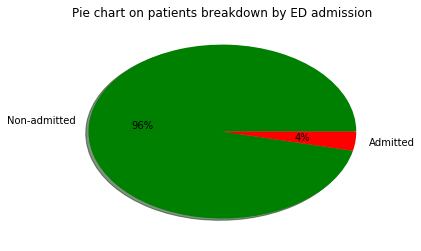

In [14]:
###############################################################################
# Data Science Portfolio: ED Admission Data Exploration
###############################################################################
# Compute summary stat.: post-data cleansing 
df_stat_post = df_cleaned.describe().T
# Reorder columns order in summary dataframe
df_stat_post = df_stat_post[['count','min','max','mean','25%','50%','75%','std']]
# drop non-numerical and meaningless features
df_stat_post = df_stat_post.drop(['Admit'])
df_stat_post

# Count frequencies and shows patients breakdown by ED admission:
df_group_admit = pd.DataFrame(df_cleaned.groupby('Admit')['Admit'].count())
df_group_admit.columns = ['count']
plt.pie(df_group_admit, labels=['Non-admitted','Admitted'], autopct='%.0f%%', colors=['green','red'], shadow=True)
plt.title('Pie chart on patients breakdown by ED admission')
plt.show()

### Count frequencies: on a stroke condition grouped by demographics and diagnostic factors ###

In [15]:
# Count frequencies: demographic factors on ED admission
###############################################################################
df_grp_gender = pd.DataFrame(df_cleaned.groupby(['Admit','Gender'])['Gender'].count())
df_grp_gender.columns = ['count']

df_grp_ethnicity = pd.DataFrame(df_cleaned.groupby(['Admit','Ethnicity'])['Ethnicity'].count())
df_grp_ethnicity.columns = ['count']

df_grp_lihn = pd.DataFrame(df_cleaned.groupby(['Admit','LIHN'])['LIHN'].count())
df_grp_lihn.columns = ['count']

df_grp_ref_diag1 = pd.DataFrame(df_cleaned.groupby(['Admit','Referral_Diagnosis_1'])['Referral_Diagnosis_1'].count().sort_values(ascending=False))
df_grp_ref_diag1.columns = ['count']

# Count frequencies: health monitoring metrics/indicators on ED admission
###############################################################################
df_grp_allergy = pd.DataFrame(df_cleaned.groupby(['Admit','Allergy'])['Allergy'].count())
df_grp_allergy.columns = ['count']

df_grp_fam_history = pd.DataFrame(df_cleaned.groupby(['Admit','Family_History'])['Family_History'].count())
df_grp_fam_history.columns = ['count']

df_grp_med = pd.DataFrame(df_cleaned.groupby(['Admit','Previous_Medication'])['Previous_Medication'].count())
df_grp_med.columns = ['count']

df_grp_painscore = pd.DataFrame(df_cleaned.groupby(['Admit','Pain_Score'])['Pain_Score'].count())
df_grp_painscore.columns = ['count']

df_grp_nausiascore = pd.DataFrame(df_cleaned.groupby(['Admit','Nausia_Score'])['Nausia_Score'].count())
df_grp_nausiascore.columns = ['count']

df_grp_gp_visits = pd.DataFrame(df_cleaned.groupby(['Admit','GP_Visits'])['GP_Visits'].count())
df_grp_gp_visits.columns = ['count']

df_grp_ed_visits = pd.DataFrame(df_cleaned.groupby(['Admit','ED_Visits'])['ED_Visits'].count())
df_grp_ed_visits.columns = ['count']

df_grp_hosp_adm = pd.DataFrame(df_cleaned.groupby(['Admit','Hospital_Admissions'])['Hospital_Admissions'].count())
df_grp_hosp_adm.columns = ['count']

### Proporition of only stroke patients: by demographic & diagnostic factors ###

In [16]:
# Proportion: only ED admitted cases by gender
df_grp_gender_1 = df_grp_gender.loc[1]
df_grp_gender_1['pct'] = (df_grp_gender_1/df_grp_gender_1.sum())*100
df_grp_gender_1['pct']

Gender
Female    40.298507
Male      59.701493
Name: pct, dtype: float64

In [17]:
# Proportion: only ED admitted cases by ethnicity
df_grp_ethnicity_1 = df_grp_ethnicity.loc[1]
df_grp_ethnicity_1['pct'] = (df_grp_ethnicity_1/df_grp_ethnicity_1.sum())*100
df_grp_ethnicity_1['pct'].sort_values(ascending=False)

Ethnicity
C    68.330224
H    10.914179
B     8.348881
A     8.255597
O     2.285448
N     1.352612
I     0.513060
Name: pct, dtype: float64

In [18]:
# Proportion: only ED admitted cases by allergy
df_grp_allergy_1 = df_grp_allergy.loc[1]
df_grp_allergy_1['pct'] = (df_grp_allergy_1/df_grp_allergy_1.sum())*100
df_grp_allergy_1['pct'].sort_values(ascending=False)

Allergy
No     58.86194
Yes    41.13806
Name: pct, dtype: float64

In [19]:
# Proportion: only ED admitted cases by family history
df_grp_fam_history_1 = df_grp_fam_history.loc[1]
df_grp_fam_history_1['pct'] = (df_grp_fam_history_1/df_grp_fam_history_1.sum())*100
df_grp_fam_history_1['pct'].sort_values(ascending=False)

Family_History
Yes    100
Name: pct, dtype: int64

In [20]:
# Proportion: only ED admitted cases by # of medications
df_grp_med_1 = df_grp_med.loc[1]
df_grp_med_1['pct'] = (df_grp_med_1/df_grp_med_1.sum())*100
df_grp_med_1['pct'].sort_values(ascending=False)

Previous_Medication
0    72.341418
1    25.326493
2     2.192164
3     0.139925
Name: pct, dtype: float64

In [21]:
# Proportion: only ED admitted cases by pain score
df_grp_painscore_1 = df_grp_painscore.loc[1]
df_grp_painscore_1['pct'] = (df_grp_painscore_1/df_grp_painscore_1.sum())*100
df_grp_painscore_1['pct'].sort_values(ascending=False)

Pain_Score
5    61.240672
1    22.481343
2    11.940299
3     4.337687
Name: pct, dtype: float64

In [22]:
# Proportion: only ED admitted cases by nausia score
df_grp_nausiascore_1 = df_grp_nausiascore.loc[1]
df_grp_nausiascore_1['pct'] = (df_grp_nausiascore_1/df_grp_nausiascore_1.sum())*100
df_grp_nausiascore_1['pct'].sort_values(ascending=False)

Nausia_Score
2    82.229478
1    13.013060
3     3.264925
4     1.492537
Name: pct, dtype: float64

In [23]:
# Proportion: only ED admitted cases by GP visits
df_grp_gp_visits_1 = df_grp_gp_visits.loc[1]
df_grp_gp_visits_1['pct'] = (df_grp_gp_visits_1/df_grp_gp_visits_1.sum())*100
df_grp_gp_visits_1['pct'].sort_values(ascending=False)

GP_Visits
5     16.604478
4     14.598881
6     12.873134
3     11.473881
7     11.380597
8      9.421642
2      7.229478
9      5.270522
10     3.917910
1      2.845149
11     2.145522
12     0.839552
13     0.559701
14     0.513060
0      0.093284
15     0.093284
19     0.046642
17     0.046642
21     0.046642
Name: pct, dtype: float64

In [24]:
# Proportion: only ED admitted cases by ED visits
df_grp_ed_visits_1 = df_grp_ed_visits.loc[1]
df_grp_ed_visits_1['pct'] = (df_grp_ed_visits_1/df_grp_ed_visits_1.sum())*100
df_grp_ed_visits_1['pct'].sort_values(ascending=False)

ED_Visits
0    59.328358
1    30.037313
2     8.535448
3     1.679104
4     0.279851
5     0.139925
Name: pct, dtype: float64

In [25]:
# Proportion: only ED admitted cases by hospital admissions
df_grp_hosp_adm_1 = df_grp_hosp_adm.loc[1]
df_grp_hosp_adm_1['pct'] = (df_grp_hosp_adm_1/df_grp_hosp_adm_1.sum())*100
df_grp_hosp_adm_1['pct'].sort_values(ascending=False)

Hospital_Admissions
0    91.231343
1     7.602612
2     0.886194
3     0.186567
5     0.046642
4     0.046642
Name: pct, dtype: float64

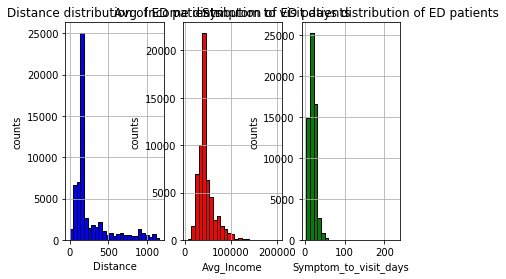

In [26]:
# Visualization: continuous/discrete - scale
###############################################################################
plt.tight_layout()
# Histogram: Distance
plt.subplot(1,3,1)
df_cleaned['Distance'].hist(bins=25, facecolor = 'blue', edgecolor='black')
plt.title('Distance distribution of ED patients')
plt.xlabel('Distance')
plt.ylabel('counts')

# Histogram: Avg_Income
plt.subplot(1,3,2)
df_cleaned['Avg_Income'].hist(bins=25, facecolor = 'red', edgecolor='black')
plt.title('Avg. Income distribution of ED patients')
plt.xlabel('Avg_Income')
plt.ylabel('counts')

# Histogram: Symptom2Visit_Days
plt.subplot(1,3,3)
df_cleaned['Symptom2Visit_Days'].hist(bins=24, facecolor = 'green', edgecolor='black')
plt.title('Symptom to visit days distribution of ED patients')
plt.xlabel('Symptom_to_visit_days')
plt.ylabel('counts')
plt.show()

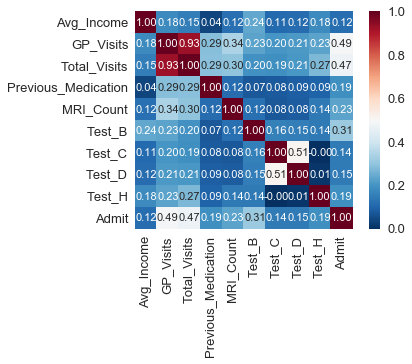

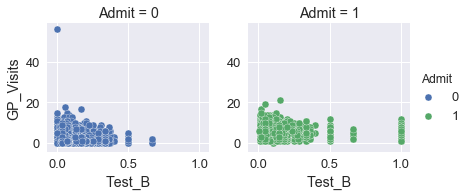

In [27]:
# Correlation Matrix Plot # entire dataset
###############################################################################
# Column names of cleaned dataframe
cols = ['Avg_Income', 'GP_Visits', 'Total_Visits',
        'Previous_Medication', 'MRI_Count',
        'Test_B', 'Test_C', 'Test_D', 'Test_H', 'Admit']

# Plot correlation matrix heatmap
#plt.figure()
cm = np.corrcoef(df_cleaned[cols].values.T)
sns.set(font_scale = 1.3)
hm = sns.heatmap(cm, cmap='RdBu_r', cbar=True,
                 annot=True, square=True, fmt='.2f',
                 annot_kws={'size':11}, yticklabels=cols, xticklabels=cols)
plt.show()

# Scatter Plot # entire dataset
###############################################################################
# Scatter Plot: GP_Visits vs. Test_B on ED admission
#plt.figure()
_ = sns.FacetGrid(df_cleaned, col='Admit', hue='Admit')
_ = (_.map(plt.scatter, 'Test_B', 'GP_Visits', edgecolor='white').add_legend())
plt.show()

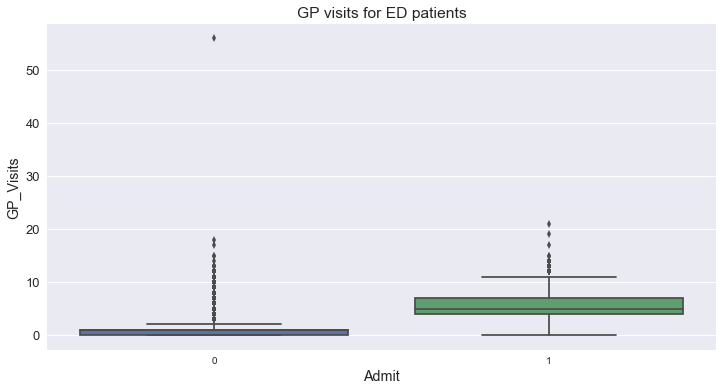

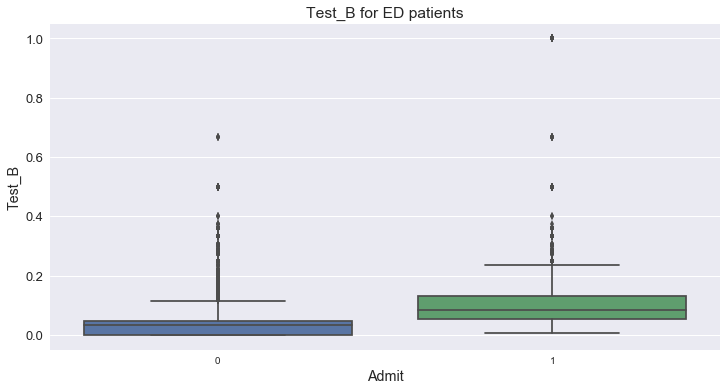

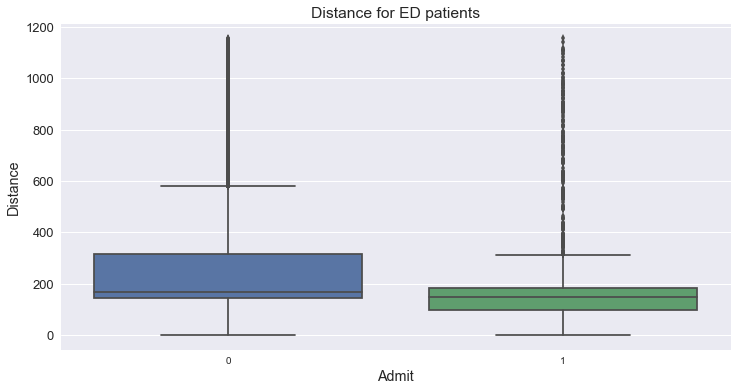

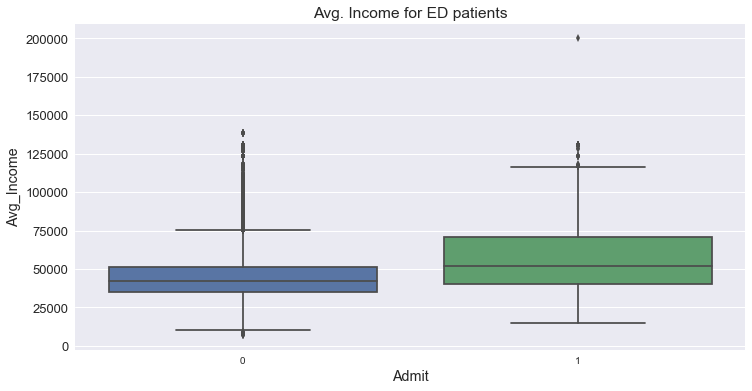

In [28]:
# Visualization: categorical and scale 
# Box-Whisker Plot #
plt.figure(figsize = (12, 6))
plt.title('GP visits for ED patients')
sns.boxplot(x = 'Admit', y = 'GP_Visits',  data = df_cleaned)
xt = plt.xticks(rotation=0, fontsize=10)
plt.show()

plt.figure(figsize = (12, 6))
plt.title('Test_B for ED patients')
sns.boxplot(x = 'Admit', y = 'Test_B',  data = df_cleaned)
xt = plt.xticks(rotation=0, fontsize=10)
plt.show()

plt.figure(figsize = (12, 6))
plt.title('Distance for ED patients')
sns.boxplot(x = 'Admit', y = 'Distance',  data = df_cleaned)
xt = plt.xticks(rotation=0, fontsize=10)
plt.show()

plt.figure(figsize = (12, 6))
plt.title('Avg. Income for ED patients')
sns.boxplot(x = 'Admit', y = 'Avg_Income',  data = df_cleaned)
xt = plt.xticks(rotation=0, fontsize=10)
plt.show()

### EDA: ED admitted cases only ###

C:\Users\yoots\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\yoots\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


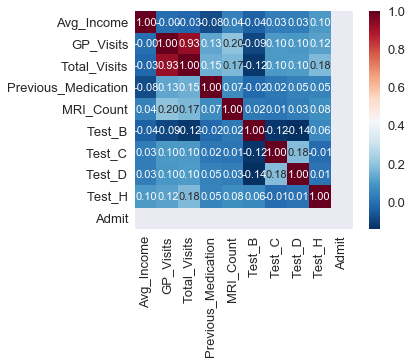

In [29]:
# Filtered dataframe by Admit label: '0':non-admitted, '1':admitted #
###############################################################################
df_admit_0 = df_cleaned[df_cleaned['Admit'] == 0] # only ED non-admitted patients
df_admit_1 = df_cleaned[df_cleaned['Admit'] == 1] # only ED admitted patients

# Extracted columns for correlation matrix plot:
cols1 = ['Avg_Income', 'GP_Visits', 'Total_Visits',
        'Previous_Medication', 'MRI_Count',
        'Test_B', 'Test_C', 'Test_D', 'Test_H', 'Admit']

# Correlation Matrix Plot #
# CM plot of ED admitted patients only:
plt.figure()
cm = np.corrcoef(df_admit_1[cols1].values.T)
sns.set(font_scale = 1.3)
hm = sns.heatmap(cm, cmap='RdBu_r', cbar=True,
                 annot=True, square=True, fmt='.2f',
                 annot_kws={'size':11}, yticklabels=cols, xticklabels=cols)
plt.show()

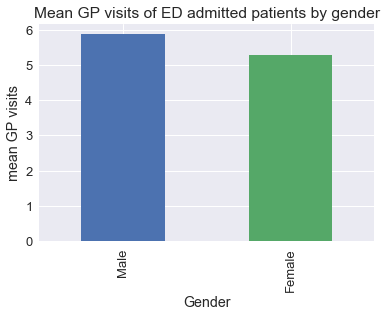

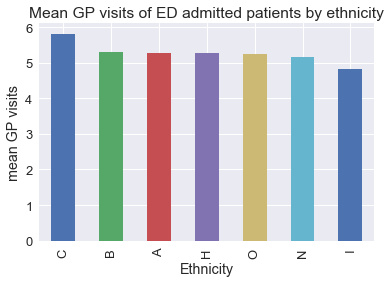

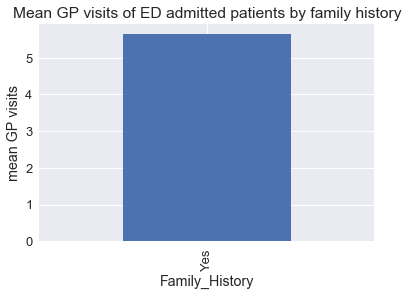

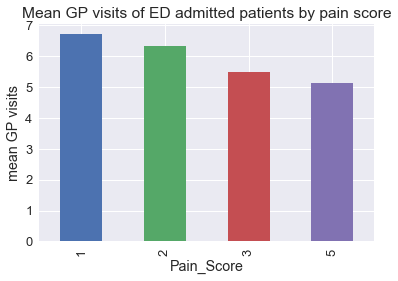

In [30]:
# Visualization: categorical data #
# Bar Charts: mean GP_Visits of ED admitted patients by demographic factors
# Gender:
df_admit_1.groupby('Gender')['GP_Visits'].mean().sort_values(ascending=False).plot(kind='bar').set_xlabel('Gender')
plt.ylabel('mean GP visits')
plt.title('Mean GP visits of ED admitted patients by gender')
plt.show()

# Ethnicity:
df_admit_1.groupby('Ethnicity')['GP_Visits'].mean().sort_values(ascending=False).plot(kind='bar').set_xlabel('Ethnicity')
plt.ylabel('mean GP visits')
plt.title('Mean GP visits of ED admitted patients by ethnicity')
plt.show()

# Bar Charts: mean GP_Visits of ED admitted patients by health monitoring factors
# Family_History:
plt.figure()
df_admit_1.groupby('Family_History')['GP_Visits'].mean().sort_values(ascending=False).plot(kind='bar').set_xlabel('Family_History')
plt.ylabel('mean GP visits')
plt.title('Mean GP visits of ED admitted patients by family history')
plt.show()

# Pain_Score:
plt.figure()
df_admit_1.groupby('Pain_Score')['GP_Visits'].mean().sort_values(ascending=False).plot(kind='bar').set_xlabel('Pain_Score')
plt.ylabel('mean GP visits')
plt.title('Mean GP visits of ED admitted patients by pain score')
plt.show()

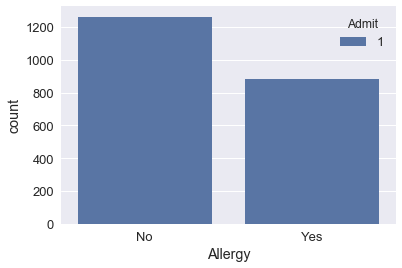

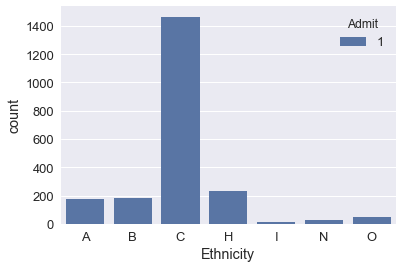

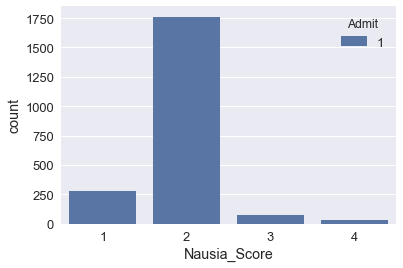

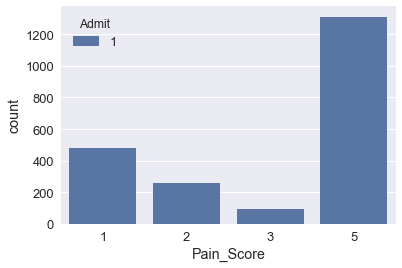

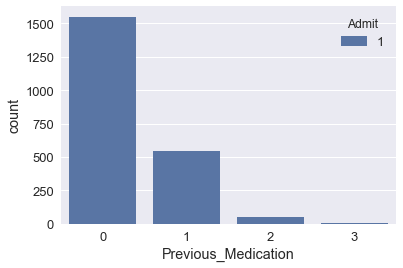

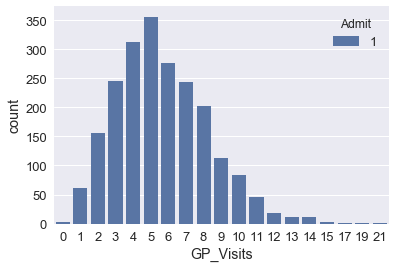

In [31]:
# Bar charts on health indicator factors on ED admitted patients #
plt.figure()
sns.countplot(x='Allergy', hue='Admit', data=df_admit_1)
plt.show()

plt.figure()
sns.countplot(x='Ethnicity', hue='Admit', data=df_admit_1)
plt.show()

plt.figure()
sns.countplot(x='Nausia_Score', hue='Admit', data=df_admit_1)
plt.show()

plt.figure()
sns.countplot(x='Pain_Score', hue='Admit', data=df_admit_1)
plt.show()

plt.figure()
sns.countplot(x='Previous_Medication', hue='Admit', data=df_admit_1)
plt.show()

plt.figure()
sns.countplot(x='GP_Visits', hue='Admit', data=df_admit_1)
plt.show()

### Compute Summary Statistics: ED admitted vs non-admitted cases ###
Computer summary statistics and report on numerical features only!

In [32]:
# Compute summary statistics #
###############################################################################
# ED admitted patients only:
df_admit_1_stat = df_admit_1.describe().T
# Reorder columns order in summary dataframe
df_admit_1_stat = df_admit_1_stat[['count','min','max','mean','25%','50%','75%','std']]
# Drop 'Admit' column:
df_admit_1_stat = df_admit_1_stat.drop(['Admit'])
# Print summary stat.:
print(df_admit_1_stat)

# ED non-admitted patients only:
df_admit_0_stat = df_admit_0.describe().T
# Reorder columns order in summary dataframe
df_admit_0_stat = df_admit_0_stat[['count','min','max','mean','25%','50%','75%','std']]
# Drop 'Admit' column:
df_admit_0_stat = df_admit_0_stat.drop(['Admit'])
# Print summary stat.:
print(df_admit_0_stat)

                      count           min            max          mean  \
Avg_Income           2144.0  15058.000000  200001.000000  57192.554571   
Distance             2144.0      2.198764    1154.751207    208.923002   
GP_Visits            2144.0      0.000000      21.000000      5.642257   
ED_Visits            2144.0      0.000000       5.000000      0.539646   
Specialist_Visits    2144.0      0.000000       9.000000      0.610075   
Hospital_Admissions  2144.0      0.000000       5.000000      0.103545   
Total_Visits         2144.0      1.000000      28.000000      6.895522   
MRI_Count            2144.0      0.000000       2.000000      0.273787   
Pain_Score           2144.0      1.000000       5.000000      3.655784   
Nausia_Score         2144.0      1.000000       4.000000      1.932369   
Previous_Medication  2144.0      0.000000       3.000000      0.301306   
Symptom2Visit_Days   2144.0      4.000000      66.000000     18.661847   
Test_B               2144.0      0.006

### Dealing with class imbalance problem on ED dataset ###
Class imbalance with low prevalence of true positive cases (i.e., ED admitted cases) are the most common problem in healthcare analytics for any classification problems. For example, in ED dataset 96% of cases were non-admitted and only 4% of cases were ED admitted. Thus, if class imbalance in the dataset is not handled properly, ML model will end up with predicting one major dominant class label which is "non-admitted" cases in the problem statement. Therefore, even if the ML model's has high accuracy, that does not really mean that the ML model is meaningful for making prognosis.

Class imbalance adjustment is resolved by executing random downsampling on sample of non-admitted cases to match the total number of ED admitted cases. This will help the modeling to start with equal proportion of labels and higher prevalence (i.e., 50% of ED admitted cases to predict from entire sample).

In [33]:
# Downsampling on non-admitted sample to match proportion of admitted cases:
######################################################################################
df_admit_0_downsampled = resample(df_admit_0, replace=True, 
                               n_samples=2144,random_state=0)

# Combine minority class '1': stroke patients with downsampled majority class:
df_downsampled = pd.concat([df_admit_0_downsampled,df_admit_1],axis=0)

# Check # of class label: admit vs. non-admit
df_downsampled['Admit'].value_counts()

1    2144
0    2144
Name: Admit, dtype: int64

### EDA: random downsampled on non-admitted casees ###

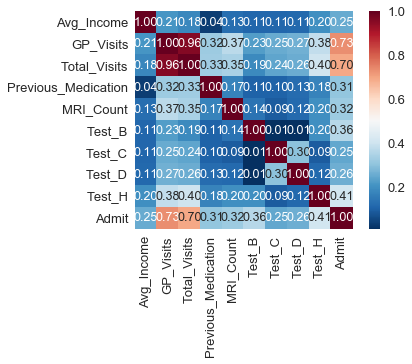

In [34]:
# Correlation Matrix Plot # random downsampled dataset (1:1 ratio)
###############################################################################
# CM plot of randomized downsampled dataset:
cm_downsampled = np.corrcoef(df_downsampled[cols].values.T)
sns.set(font_scale = 1.3)
hm = sns.heatmap(cm_downsampled, cmap='RdBu_r', cbar=True,
                 annot=True, square=True, fmt='.2f',
                 annot_kws={'size':12.5}, yticklabels=cols, xticklabels=cols)
plt.show()

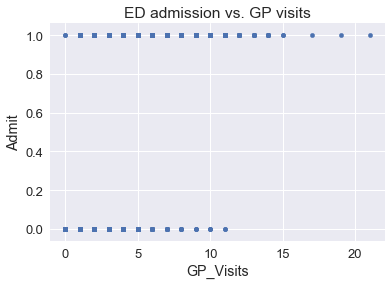

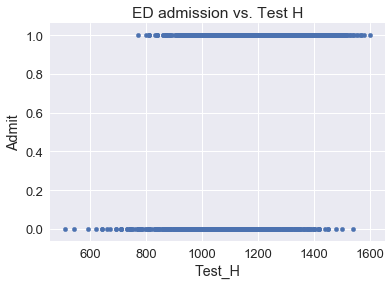

In [35]:
# Scatter Plot: downsampled dataset
############################################################################### 
# Admit vs. GP_Visits
df_downsampled.plot(kind='scatter', x='GP_Visits', y='Admit', linestyle='None')
plt.title('ED admission vs. GP visits')
plt.show()

# Admit vs. Test_H
df_downsampled.plot(kind='scatter', x='Test_H', y='Admit', linestyle='None')
plt.title('ED admission vs. Test H')
plt.show()

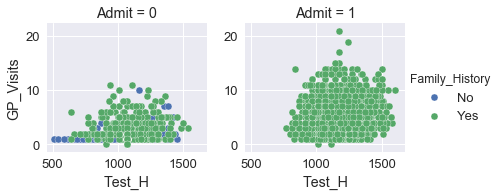

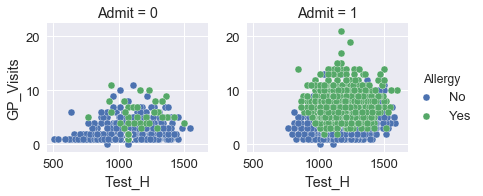

In [36]:
# Faceted Scatter Plot: downsampled dataset
############################################################################### 
# Test_H vs. GP_Visits by Family History
_ = sns.FacetGrid(df_downsampled, col='Admit', hue='Family_History', hue_order=['No','Yes'])
_ = (_.map(plt.scatter, 'Test_H', 'GP_Visits', edgecolor='white').add_legend())
plt.show()

# Test_H vs. GP_Visits by Allergy 
_ = sns.FacetGrid(df_downsampled, col='Admit', hue='Allergy')
_ = (_.map(plt.scatter, 'Test_H', 'GP_Visits', edgecolor='white').add_legend())
plt.show()

### Dummy Variable Encoding: nominal features ###
Dummy variable encoding on nominal feature allows to create a separate column on each feature and its value are only encoded "0" or "1". This dummy indicator get interpreted well to the ML models for making accurate prediction. Also to reduce any potential biases of having multi-colinearity, each feature's first encoded dummy variable must be dropped to avoid dummy variable trap (i.e., where independent variables are highly inter-correlated with each other as one predictor can be predicted from other of similar variables: gender_female vs. gender_male).

In [37]:
# Encode features on Gender, Allergy, Family_History:
df_downsampled['Gender'] = df_downsampled['Gender'].map(inv_Gender_map)
df_downsampled['Allergy'] = df_downsampled['Allergy'].map(inv_Yes_No_map)
df_downsampled['Family_History'] = df_downsampled['Family_History'].map(inv_Yes_No_map)

# Encode back to admission date format:
df_downsampled['Admission_Date'] = df_downsampled['Admission_Date'].map(adm_date_mapping)

# Check re-formatted on random down resampled dataframe:
df_downsampled.head()

# Check unique entities on following categorical features:
np.count_nonzero(df_downsampled['Referral_Diagnosis_1'].unique()) #105 features
np.count_nonzero(df_downsampled['Referral_Diagnosis_2'].unique()) #101 features
np.count_nonzero(df_downsampled['GP_Code'].unique()) #1490 features
np.count_nonzero(df_downsampled['LIHN'].unique()) #10 features
np.count_nonzero(df_downsampled['Ethnicity'].unique()) #7 features
np.count_nonzero(df_downsampled['Test_A'].unique()) #2 features
np.count_nonzero(df_downsampled['Test_F'].unique()) #1 features
np.count_nonzero(df_downsampled['Test_G'].unique()) # 88 features

# Remove: Ref_Diagnosis_1,Ref_Diagnosis_1,GP_Code

# Dummy Variable Encoding: nominal features #
###############################################################################
# Drop first dummy variable on each nominal feature to avoid dummy variable trap:
df_encoded = pd.get_dummies(df_downsampled[['Gender', 'Ethnicity', 'LIHN', 'Avg_Income', 'Distance', 'GP_Visits',
                                                'ED_Visits', 'Specialist_Visits', 'Hospital_Admissions', 'Total_Visits',
                                                'MRI_Count','Pain_Score', 'Nausia_Score', 'Allergy', 'Previous_Medication',
                                                'Family_History', 'Symptom2Visit_Days', 'Test_A', 'Test_B', 'Test_C',
                                                'Test_D', 'Test_E', 'Test_F', 'Test_G', 'Test_H']], drop_first=True)

df_transformed = pd.concat([df_encoded,df_downsampled['Admit']], axis=1)

# Check dataframe info.:
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4288 entries, 6211 to 2233
Columns: 149 entries, Gender to Admit
dtypes: float64(6), int32(11), int64(4), uint8(128)
memory usage: 1.2 MB


## Data Modeling: Classificaion ##
This part is mainly focused on creating different types of classification model on our transformed dataset. Following classification algorithms will be tested: logistic regression, decision tree and random forest.

The model will be optimized using GridSearchCV to tune hyperparatmers within each model. This will help each model to provide the best performance on each model for achieving higher prediction on ED admitted cases classification task.

In [38]:
#########################################
# QA check on input features/class label#
# Re-define input features:
X = df_transformed.iloc[:, :-1].values
# Reduced output feature (label): stroke
y = df_downsampled['Admit'].values
# Print unique labels for stroke condition:
print('Class labels:', np.unique(y))

Class labels: [0 1]


In [39]:
###############################################################################
# General: data parition - train vs. test set
# Use built-in stratify mode to ensure equal % label splits
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 1/4, random_state = 0, stratify=y)

# Check label counts on the split set:
print('Class labels counts in total:', np.bincount(y))
print('Class labels counts in train set:', np.bincount(y_train))
print('Class labels counts in test set:', np.bincount(y_test)) 

# Feature Scaling: 
sc_X = StandardScaler() 
X_train_std = sc_X.fit_transform(X_train) 
X_test_std = sc_X.fit_transform(X_test)    

Class labels counts in total: [2144 2144]
Class labels counts in train set: [1608 1608]
Class labels counts in test set: [536 536]


In [40]:
# Feature Selection: Recursive Feature Elimination #
# Using Logistic Regression: 
lr = LogisticRegression(random_state=0)
from sklearn.feature_selection import RFE
rfe = RFE(lr, 2) 
rfe.fit(X_train_std, y_train)
print("Num Features: %d" % rfe.n_features_)
print("Selected Features: %s" % rfe.support_)
print("Feature Ranking: %s" % rfe.ranking_)

Num Features: 2
Selected Features: [False False False  True False False False False False False False False
 False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
Feature Ranking: [ 73  59  75   1  35  98  42   8  19  34   9  

In [41]:
################################
# Model 1: Logistic Regression #
################################
###############################################################################
# Feature Selection by LogisticReg + RFE #
# Reduced features: Family_History, Test_B 
X_lr = X_train_std[:, [13,15]]
y_lr = y_train

# K-fold Cross-validation: Stratified #
# Logistic Regression:
skf = StratifiedKFold(n_splits=4, random_state=0)
for train_index, test_index in skf.split(X_lr, y_lr):
#    print("TRAIN:", train_index,  "TEST:", test_index)
    X_train_lr, X_test_lr = X_lr[train_index], X_lr[test_index]
    y_train_lr, y_test_lr = y_lr[train_index], y_lr[test_index]

In [42]:
# Model: Logistic Regression
lr_cv = LogisticRegression(C=0.1,penalty='l1',random_state=0)
lr_cv.fit(X_train_lr, y_train_lr)

# Hyperparameters Tuning: ML Models #
# import library
from sklearn.model_selection import GridSearchCV

# GridSearchCV: LogisticRegression #
parameters_lr = [{'C': [0.01, 0.1, 1, 5, 10], 'penalty': ['l1', 'l2']}]
if __name__ == '__main__':
    grid_search_lr = GridSearchCV(estimator = lr_cv,
                               param_grid = parameters_lr,
                               scoring = 'roc_auc',
                               cv = 4,
                               n_jobs = 1)
grid_search_lr = grid_search_lr.fit(X_train_lr, y_train_lr)
best_roc_auc_lr = grid_search_lr.best_score_
best_parameters_lr = grid_search_lr.best_params_
best_parameters_lr

# Model prediction: CV testset
y_pred_test_lr = grid_search_lr.predict(X_test_lr)

 1) GP_Visits                      0.783351
 2) Test_B                         0.068584
 3) Family_History                 0.058502
 4) Test_G_LMA                     0.057445
 5) Test_H                         0.030824
 6) Ethnicity_I                    0.001293
 7) Test_G_WPR                     0.000000
 8) Test_G_C02                     0.000000
 9) Test_G_CCD                     0.000000
10) Test_G_CAV                     0.000000
11) Test_G_C04                     0.000000
12) Test_G_C03                     0.000000
13) Test_G_C01                     0.000000
14) Test_G_CIP                     0.000000
15) Test_G_BST                     0.000000
16) Test_G_BHC                     0.000000
17) Test_G_ATH                     0.000000
18) Test_G_APP                     0.000000
19) Test_G_ANP                     0.000000
20) Test_G_AGN                     0.000000
21) Test_G_ACT                     0.000000
22) Test_G_CCU                     0.000000
23) Test_G_CLT                  

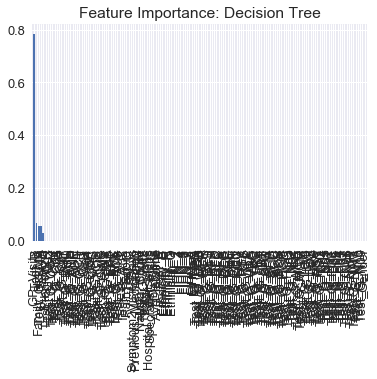

In [43]:
###############################################################################
# Feature Selection: Feature Importance #
# Using a Decision Tree:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='gini',
                                max_depth=4,
                                random_state=0)
feat_labels = df_transformed.columns[:-1]
tree.fit(X_train_std, y_train)
importances = tree.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]],
                            importances[indices[f]]))

plt.title('Feature Importance: Decision Tree')
plt.bar(range(X_train_std.shape[1]),
        importances[indices],
        align='center')
plt.xticks(range(X_train_std.shape[1]),
           feat_labels[indices], rotation=90)
plt.xlim(-1, X_train_std.shape[1])
plt.show()

In [44]:
####################################
# Model 2: DecisionTree Classifier #
####################################
# Feature Selection by DT Classifier: GP_Visits, Test_B
X_dt = X_train_std[:, [3,15]]
y_dt = y_train

# K-fold Cross-validation: Stratified #
# DecisionTree Classifier:
for train_index, test_index in skf.split(X_dt, y_dt):
#   print("TRAIN:", train_index,  "TEST:", test_index)
    X_train_dt, X_test_dt = X_dt[train_index], X_dt[test_index]
    y_train_dt, y_test_dt = y_dt[train_index], y_dt[test_index]

In [45]:
# Model: DecisionTree [cross-validated & std. train set]
tree_cv = DecisionTreeClassifier(criterion='gini', max_depth=8,
                                min_samples_split=2, min_samples_leaf=2,
                                random_state=0)
tree_cv.fit(X_train_dt, y_train_dt)

# GridSearchCV: DecisionTree #
parameters_dt = [{'max_depth': [1,2,4,6,8,10],'min_samples_split':[2,5,10], 
                  'min_samples_leaf':[1,2]}]
if __name__ == '__main__':
    grid_search_dt = GridSearchCV(estimator = tree_cv,
                               param_grid = parameters_dt,
                               scoring = 'roc_auc',
                               cv = 4,
                               n_jobs = 1)
grid_search_dt = grid_search_dt.fit(X_train_dt, y_train_dt)
best_roc_auc_dt = grid_search_dt.best_score_
best_parameters_dt = grid_search_dt.best_params_
best_parameters_dt

# Model prediction: CV testset
y_pred_test_dt = grid_search_dt.predict(X_test_dt)

 1) GP_Visits                      0.236181
 2) Test_B                         0.130592
 3) Total_Visits                   0.102315
 4) Test_H                         0.097657
 5) Family_History                 0.077453
 6) Allergy                        0.043168
 7) Avg_Income                     0.028273
 8) Symptom2Visit_Days             0.022110
 9) Distance                       0.020783
10) Test_D                         0.020655
11) Test_C                         0.020382
12) Nausia_Score                   0.020360
13) Test_G_LMA                     0.016541
14) Previous_Medication            0.015967
15) Ethnicity_N                    0.015960
16) MRI_Count                      0.015816
17) Test_E                         0.011362
18) Test_A_Y                       0.008729
19) Specialist_Visits              0.007983
20) Pain_Score                     0.007154
21) ED_Visits                      0.006772
22) Ethnicity_C                    0.005746
23) Test_G_SAT                  

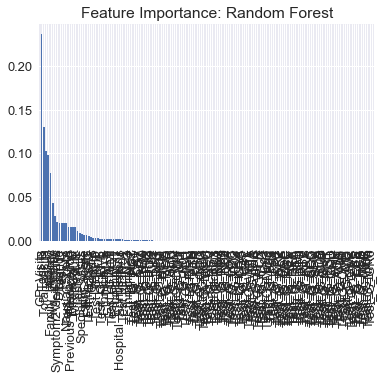

In [46]:
###############################################################################
# Feature Selection: Feature Importance #
# Using a Random Forest:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(criterion='gini',
                                n_estimators=25,
                                random_state=0,
                                n_jobs=1)
feat_labels = df_transformed.columns[:-1]
forest.fit(X_train_std, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]],
                            importances[indices[f]]))

plt.figure()    
plt.title('Feature Importance: Random Forest')
plt.bar(range(X_train_std.shape[1]),
        importances[indices],
        align='center')
plt.xticks(range(X_train_std.shape[1]),
           feat_labels[indices], rotation=90)
plt.xlim(-1, X_train.shape[1])
plt.show() 

In [47]:
####################################
# Model 3: RandomForest Classifier #
####################################
# Feature Selection by RF Classifier: Total_Visits, GP_Visits
X_rf = X_train_std[:, [7,3]]
y_rf = y_train

# K-fold Cross-validation: Stratified #
# RandomForest Classifier:
for train_index, test_index in skf.split(X_rf, y_rf):
#   print("TRAIN:", train_index,  "TEST:", test_index)
   X_train_rf, X_test_rf = X_rf[train_index], X_rf[test_index]
   y_train_rf, y_test_rf = y_rf[train_index], y_rf[test_index]

In [48]:
# Model: RandomForest [cross-validated & std. train set]
forest_cv = RandomForestClassifier(criterion='gini',n_estimators=50,
                                max_depth=1, min_samples_split=2,
                                random_state=0, n_jobs=1)
forest_cv.fit(X_train_rf, y_train_rf)

# GridSearchCV: RandomForest #
parameters_rf = [{'n_estimators': [1,10,20,50,100], 'max_depth': [1,5,10],
                  'min_samples_split':[2,5,10]}]
if __name__ == '__main__':
    grid_search_rf = GridSearchCV(estimator = forest_cv,
                               param_grid = parameters_rf,
                               scoring = 'roc_auc',
                               cv = 4,
                               n_jobs = 1)
grid_search_rf = grid_search_rf.fit(X_train_rf, y_train_rf)
best_roc_auc_rf = grid_search_rf.best_score_
best_parameters_rf = grid_search_rf.best_params_
best_parameters_rf

# Model prediction: CV testset
y_pred_test_rf = grid_search_rf.predict(X_test_rf)

## Model Evaluation: Confusion Matrix & ROC curve ##
A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.

1. True Positives (TP): These are cases in which we predicted yes (they have the disease), and they do have the disease.
2. True Negatives (TN): We predicted no, and they don't have the disease.
3. False Positives (FP): We predicted yes, but they don't actually have the disease. (Also known as a "Type I error.")
4. False Negatives (FN): We predicted no, but they actually do have the disease. (Also known as a "Type II error.")

ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

The “steepness” of ROC curves is also important, since it is ideal to maximize the true positive rate while minimizing the false positive rate.

In [49]:
# Making the Confusion/Contingency Matrix #
#############################################################################

# Write plot_confusion_matrix function #
def plot_confusion_matrix(cm):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i, s=cm[i,j],va='center',ha='center')
        plt.xlabel('predicted label')
        plt.ylabel('true label')

# Compute confusion matrix on Stratified K-fold test set: 4 ML modelings
cm_test_lr = confusion_matrix(y_test_lr, y_pred_test_lr)  
cm_test_dt = confusion_matrix(y_test_dt, y_pred_test_dt)  
cm_test_rf = confusion_matrix(y_test_rf, y_pred_test_rf)

# Class label names:
target_names = ['non-admitted', 'admitted']

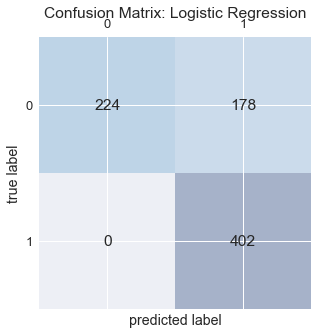

              precision    recall  f1-score   support

non-admitted       1.00      0.56      0.72       402
    admitted       0.69      1.00      0.82       402

 avg / total       0.85      0.78      0.77       804

ROC score of LogisticRegression is 0.78


In [50]:
# Plot confusion matrix on test set: LogisticRegression
###############################################################
plot_confusion_matrix(cm_test_lr)
plt.title('Confusion Matrix: Logistic Regression')
plt.show()

# Classification report on test set: LogisticRegression
print(classification_report(y_test_lr, y_pred_test_lr, 
                            target_names=target_names))

# ROC score on test set: LogisticRegression
print('ROC score of LogisticRegression is %0.2f'% roc_auc_score(y_test_lr, y_pred_test_lr))

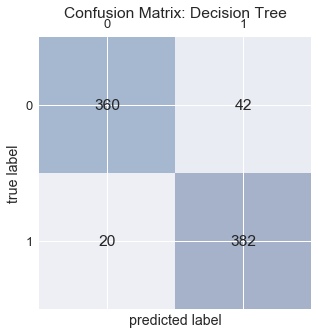

              precision    recall  f1-score   support

non-admitted       0.95      0.90      0.92       402
    admitted       0.90      0.95      0.92       402

 avg / total       0.92      0.92      0.92       804

ROC score of DecisionTree is 0.92


In [51]:
# Plot confusion matrix on test set: DecisionTree
###############################################################
plot_confusion_matrix(cm_test_dt)
plt.title('Confusion Matrix: Decision Tree')
plt.show()

# Classification report on test set: DecisionTree
print(classification_report(y_test_dt, y_pred_test_dt, 
                            target_names=target_names))

# ROC score on test set: DecisionTree
print('ROC score of DecisionTree is %0.2f'% roc_auc_score(y_test_dt, y_pred_test_dt))

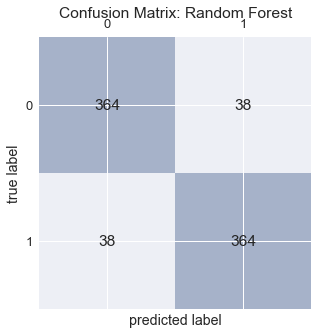

              precision    recall  f1-score   support

non-admitted       0.91      0.91      0.91       402
    admitted       0.91      0.91      0.91       402

 avg / total       0.91      0.91      0.91       804

ROC score of RandomForest is 0.91


In [52]:
# Plot confusion matrix on test set: RandomForest
###############################################################
plot_confusion_matrix(cm_test_rf)
plt.title('Confusion Matrix: Random Forest')
plt.show()

# Classification report on test set: RandomForest
print(classification_report(y_test_rf, y_pred_test_rf, 
                            target_names=target_names))

# ROC score on test set: RandomForest
print('ROC score of RandomForest is %0.2f'% roc_auc_score(y_test_rf, y_pred_test_rf))

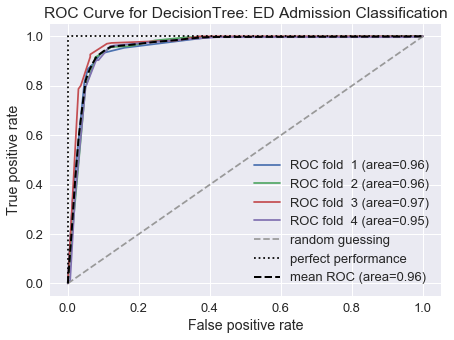

In [53]:
###############################################################
# Plotting ROC Curve #
# DecisionTree: ROC fold and Mean ROC
from sklearn.metrics import roc_curve, auc
from scipy import interp

cv = list(skf.split(X_train_dt, y_train_dt))
fig = plt.figure(figsize=(7,5))
mean_tpr = 0.0
mean_fpr = np.linspace(0,1,100)
all_trp = []

for i, (train,test) in enumerate(cv):
    prob = grid_search_dt.fit(X_train_dt[train],y_train_dt[train]).predict_proba(X_train_dt[test])
    fpr,tpr,thresholds = roc_curve(y_train_rf[test],
                                   prob[:,1],
                                   pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr,tpr,label='ROC fold % d (area=%0.2f)' % (i+1, roc_auc))
    
plt.plot([0,1],[0,1],linestyle='--',
    color=(0.6,0.6,0.6),label='random guessing')

plt.plot([0,0,1],[0,1,1],linestyle=':',
    color='black',label='perfect performance')
    
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr,mean_tpr)
    
plt.plot(mean_fpr,mean_tpr,'k--',
    label='mean ROC (area=%0.2f)' % mean_auc, lw=2)
        
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve for DecisionTree: ED Admission Classification')
plt.legend(loc='lower right')
plt.show()

In [54]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# Write plot_decision_regions function #
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # Setup marker generator and colormap
    markers = ('o','o','s','^','v')
    colors = ('red','green','blue','gray','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # Plot decision surface
    x1_min, x1_max = X[:,0].min()-1, X[:,0].max()+1
    x2_min, x2_max = X[:,1].min()-1, X[:,1].max()+1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl, 0], y=X[y==cl, 1],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=cl, edgecolor='black')

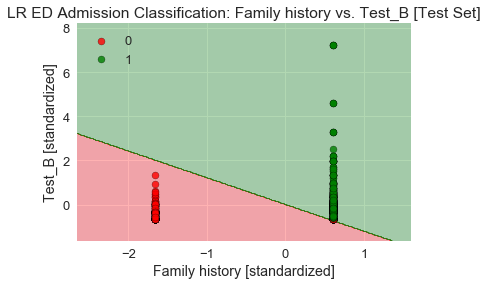

In [55]:
###############################################################################
# Visualize ED classification: Logistic Regression #
# Downsampled CV: test set
plt.figure()
plot_decision_regions(X=X_test_lr, y=y_test_lr, classifier=grid_search_lr, test_idx=None)
plt.title('LR ED Admission Classification: Family history vs. Test_B [Test Set]')
plt.xlabel('Family history [standardized]')
plt.ylabel('Test_B [standardized]')
plt.legend(loc='upper left')
plt.show()

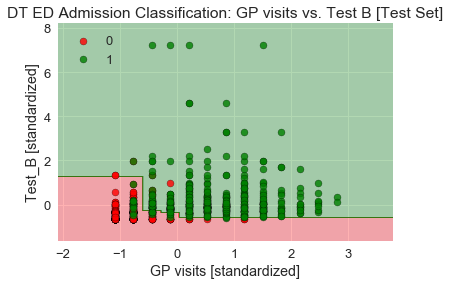

In [56]:
# Visualize ED classification: Decision Tree #
# Downsampled CV: test set
plt.figure()
plot_decision_regions(X=X_test_dt, y=y_test_dt, classifier=grid_search_dt, test_idx=None)
plt.title('DT ED Admission Classification: GP visits vs. Test B [Test Set]')
plt.xlabel('GP visits [standardized]')
plt.ylabel('Test_B [standardized]')
plt.legend(loc='upper left')
plt.show()

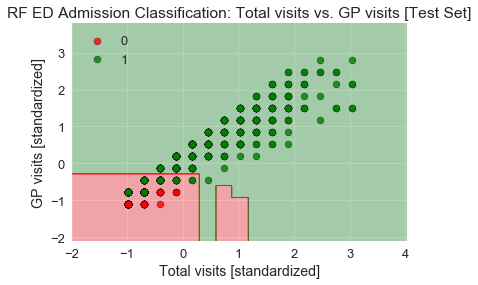

In [57]:
# Visualize ED classification: Random Forest #
# Downsampled CV: test set
plt.figure()
plot_decision_regions(X=X_test_rf, y=y_test_rf, classifier=grid_search_rf, test_idx=None)
plt.title('RF ED Admission Classification: Total visits vs. GP visits [Test Set]')
plt.xlabel('Total visits [standardized]')
plt.ylabel('GP visits [standardized]')
plt.legend(loc='upper left')
plt.show()